In [39]:
import os
import sys
import cv2

ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)

In [40]:
import numpy as np
import math
import mrcnn.model as modellib


import ICRNConfigure
from mrcnn.config import Config
from Dataset_generator_Barchart import GenerateOneBarChart

In [41]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
maskrcnnconfig = ShapesConfig()
maskrcnnconfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [42]:
RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/BarChart_color")

# load Mask RCNN

In [43]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
maskrcnn_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=RCNNMODEL_DIR)

maskrcnn_model_path = maskrcnn_model.find_last()

# Load trained weights
print("Loading weights from ", maskrcnn_model_path)
maskrcnn_model.load_weights(maskrcnn_model_path, by_name=True)

Loading weights from  /home/mahsa.geshvadi001/projects/PaperCodes/2_Comparison/Instance-based-RN/Codes_PureExperiment_default_5_times/Task1_ourNewTasks/MaskRCNNlogs/BarChart_color/cqa20230313T1326/mask_rcnn_cqa_0060.h5
Re-starting from epoch 60


# Load Test Data

In [44]:
ICRN_config = ICRNConfigure.Config()


Configurations

In [45]:
image_num = 20
min_num_obj = 3
max_num_obj = 6

Generate Test dataset

In [46]:
def get_segmented_image(segments_bbs, image):
    
    removed_image = image.copy()
    for i in range(len(segments_bbs)):
        toremovesegment = segments_bbs[i]
    
        x1 = toremovesegment[0]
        y1  = toremovesegment[2]
        x2 = toremovesegment[1]
        y2 = toremovesegment[3]

        removed_image[x1 : y1, x2 : y2] = (1, 1, 1)
        removed_image[x1 : y1, x2 : y2] =removed_image[x1 : y1, x2 : y2] +  np.random.uniform(0, 0.05, (abs(y1-x1), abs(y2-x2),3))
        _min = 0.0  # because the image is not 0/1 black-and-white image, is a RGB image.
        _max = removed_image.max()
        removed_image -= _min
        removed_image[x1 : y1, x2 : y2] /= (_max - _min)
   
    return removed_image

In [47]:
ICRNConfigure.MakeDir('testDataset')
ICRNConfigure.ClearDir('testDataset')


Resetting the folder..... testDataset


In [48]:
def saveImage(image, featureVector, i):

    file_gt = open('testDataset/ground_truth.txt', 'w')
    file_pair_gt = open('testDataset/pair_ground_truth.txt','w')
    cv2.imwrite('testDataset/' + ICRN_config.chartName.format(i), image * 255)
    
    for t in range(len(featureVector)):
        file_gt.write("%.6f\t" % (featureVector[t]))
                
    for t in range(ICRN_config.max_obj_num - len(featureVector)):
        file_gt.write("0.00\t")
        file_gt.write("\n")

    for t in range(len(featureVector) - 1):
            file_pair_gt.write("{} {} {}\n".format(ICRN_config.subChartName.format(i, t),
                                                       ICRN_config.subChartName.format(i, t + 1),
                                                       featureVector[t+1] / featureVector[t]))


In [49]:
_images = np.ones((ICRN_config.max_obj_num, image_num, ICRN_config.image_height, ICRN_config.image_width, 3), dtype='float32')
_labels = []
number_of_bars = []

In [50]:
for i in range(image_num):

        image, _, featureVector = GenerateOneBarChart(
                num=np.random.randint(min_num_obj, max_num_obj + 1))
        
        saveImage(image, featureVector, i)
        featureVector = np.array(featureVector)

        results = maskrcnn_model.detect([image], verbose=1)
        r = results[0]
        arr = r['rois']
        segments_bbs = arr[arr[:,1].argsort()]

        segments = []
        for t in range(len(r['rois'])):
            segments.append(get_segmented_image([x for x in segments_bbs if ((x != segments_bbs[t]).any())], image))

            
        subImages = [np.ones(shape=(ICRN_config.image_width,ICRN_config.image_width,3)) for i in range(ICRN_config.max_obj_num)]
        for count in range(len(r['rois'])):

            if count< 6:
                subImages[count] = segments[count]
            
        for t in range(ICRN_config.max_obj_num):
            _images[t][i] = subImages[t]

        number_of_bars.append(len(r['rois']))
        
        label = np.zeros(ICRN_config.max_obj_num, dtype='float32')
        label[:len(featureVector)] = featureVector
        _labels.append(label)
        
_labels = np.array(_labels, dtype='float32')

Processing 1 images
image                    shape: (100, 100, 3)         min:    0.03773  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.54777  max: -102.90093  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (100, 100, 3)         min:    0.00537  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.46659  max: -102.90063  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (100, 100, 3)         min:    0.01272  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.62414  max: 

In [51]:
x_test = _images

In [52]:
x_test = [x_test[i] for i in range(ICRN_config.max_obj_num)]
x_test.append(np.ones(image_num))
input_test = [x_test[i] for i in range(ICRN_config.max_obj_num)]
input_test.append(np.ones(input_test[0].shape[0]))

In [53]:
len(input_test)

7

In [54]:
_images.shape

(6, 20, 100, 100, 3)

In [55]:
import matplotlib.pyplot as plt

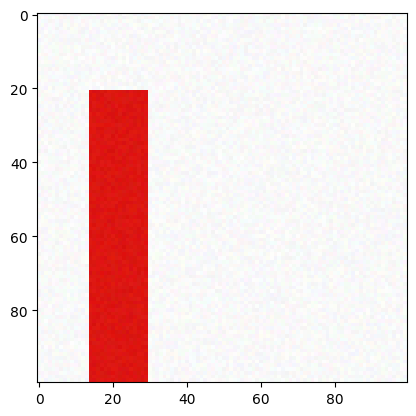

In [56]:
plt.imshow(_images[0][0])

# Predict the ratio with ICRN 

In [57]:

import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from keras.optimizers import SGD, Adam
from non_local import non_local_block
import matplotlib.pyplot as plt
import cv2
import os
import time, argparse
import pickle
import sklearn
from sklearn.metrics import mean_squared_error


In [58]:

def Level1_Module():
    input = Input(shape=(ICRN_config.image_height, ICRN_config.image_width, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = non_local_block(x)   # non local block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = non_local_block(x)   # non local block
    return Model(inputs=input, outputs=x)

# Level2 module is to compute the ratio of a pair.
# Level2 has one NON-LOCAL block.
def Level2_Module(w,h,c):
    print("Level2:", w,h,c)

    inputA = Input(shape=(w, h, c))
    inputB = Input(shape=(w, h, c))

    combined = keras.layers.concatenate([inputA, inputB])   # concatenate them.
    z = Conv2D(64, (3, 3), activation='relu',padding='same')(combined)
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
    z = non_local_block(z)   # non local block
    #
    z = Flatten()(z)
    z = Dense(256, activation="relu")(z)
    z = Dropout(0.5)(z)
    z = Dense(1, activation="linear")(z)  # output the ratio of this pair.

    return Model(inputs=[inputA, inputB], outputs=z)



# IRN_m is final network to estimate the ratio vectors from multiple input instances.
def Build_IRN_m_Network():
    # input layers.
    input_layers = []
    # the first 'obj_num' inputs are corresponding to the input sub-charts.
    for i in range(ICRN_config.max_obj_num):
        input = Input(shape=(ICRN_config.image_height, ICRN_config.image_width, 3), name="input_{}".format(i))
        input_layers.append(input)

    # The last input layer is used for representing R1=(o1/o1)=1.0 which is just a constant.
    # Here, I would use an extra input layer which is 1-dim and always equal to 1.0 rather than directly using a contant.
    # It makes same effect and can avoid some strange compile errors. (I only use TensorFlow before, not way familiar to Keras.)
    R1_one_input = Input(shape=(1,),name="input_constant_scalar1",dtype='float32')   # always equal to 1.0.
    input_layers.append(R1_one_input)

    # First extract individual features.
    individual_features = []
    level1 = Level1_Module()  # build a level1 module
    for i in range(ICRN_config.max_obj_num):
        x = level1(input_layers[i])
        individual_features.append(x)

    # Use a Level2 module to predict pairwise ratios.
    level2 = Level2_Module(w=int(individual_features[0].shape[1]),
                           h=int(individual_features[0].shape[2]),
                           c=int(individual_features[0].shape[3]))

    ratio_p_layers = [R1_one_input]   # pairwise ratio vector. put in' R1=(o1/o1)=1.0 '.
    for i in range(ICRN_config.max_obj_num-1): # compute the ratio of each neighbor pair.
        x = level2(inputs = [individual_features[i], individual_features[i+1]])
        ratio_p_layers.append(x)

    print("ratio_p_layers", len(ratio_p_layers), ratio_p_layers[-1].shape)

    # Compute the ratios relative to the first object by using MULTIPLY() operation.
    ratio_layers = [R1_one_input]  # put in R1=1.0.
    i = 1
    while i<len(ratio_p_layers):
        x = keras.layers.Multiply()(ratio_p_layers[:i+1])   # R1*R2*...Ri
        i+=1
        ratio_layers.append(x)

    # divide the maxinum of 'ratio_layers' to get the final results.
    max = keras.layers.maximum(ratio_layers)
    z = keras.layers.concatenate(ratio_layers)
    z = keras.layers.Lambda(lambda x: x[0]/x[1])([z, max])

    print("output layer: ", z.shape)

    return Model(inputs=input_layers, outputs=z)

In [59]:
model = Build_IRN_m_Network()
m_optimizer = Adam(0.0001)
model.compile(loss='mse', optimizer=m_optimizer)

Level2: 12 12 64
ratio_p_layers 6 (None, 1)
output layer:  (None, 6)


In [60]:
model.load_weights('model_IcRN_onTrain_0.00010191364316851832.h5')

In [61]:
predict_Y = model.predict(x=input_test, batch_size=1)


In [62]:
predict_Y

array([[ 1.0000000e+00,  3.5347822e-01,  2.3032595e-01,  4.5023490e-02,
         6.6435157e-04,  9.8029495e-06],
       [ 6.6480631e-01,  2.5424594e-01,  6.9756043e-01,  6.5250677e-01,
         2.1468712e-01,  1.0000000e+00],
       [ 6.3292569e-01,  1.0000000e+00,  7.6346868e-01,  7.5308692e-01,
         3.6418194e-01,  2.6710037e-02],
       [ 3.2344416e-01,  1.0000000e+00,  7.4975646e-01,  9.1602993e-01,
         2.3144695e-01, -2.6557911e-03],
       [ 1.0000000e+00,  5.9022593e-01,  6.9877434e-01,  2.2647202e-01,
         7.9054195e-01,  9.9407601e-01],
       [ 3.0712000e-01,  1.0000000e+00,  8.8862097e-01,  5.7396978e-01,
         1.0377741e-01,  3.1890869e-03],
       [ 9.6677947e-01,  8.4704798e-01,  1.0000000e+00,  7.1841419e-02,
         1.0600680e-03,  1.5642010e-05],
       [ 4.1616100e-01,  7.2767758e-01,  1.0000000e+00,  9.5504498e-01,
         7.3799491e-01,  2.2203028e-01],
       [ 5.1825392e-01,  4.9320352e-01,  8.8063365e-01,  1.0000000e+00,
         1.2368351e-01, 

In [63]:
for n in range(image_num):

        predict_Y[n][number_of_bars[n]: 6] = 0

In [64]:
y = _labels

In [65]:
MLAE = np.log2(sklearn.metrics.mean_absolute_error( predict_Y * 100, y * 100) + .125)

In [66]:
MLAE

2.063202993133363